In [1]:
import warnings

# Add autoreload magic command
%load_ext autoreload
%autoreload 2

import pickle 
import numpy as np
import pandas as pd
from IPython.display import display
# from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)


RESPONSE_VARS = ["Limonene"]

INPUT_VARS = [
    "ATOB_ECOLI",
    "ERG8_YEAST",
    "IDI_ECOLI",
    "KIME_YEAST",
    "MVD1_YEAST",
    "Q40322_MENSP",
    "Q8LKJ3_ABIGR",
    "Q9FD86_STAAU",
    "Q9FD87_STAAU",
]

DBTL_A = [
    "2X.Mh",
    "B.Lm",
    "2X.Ll",
    "A.Mm",
    "B.Ll",
    "A.Mh",
    "2X.Lm",
    "A.Hl",
    "2X.Hh",
    "B.Ml",
    "B.Mm",
    "2X.Lh",
    "B.Mh",
    "2X.Hl",
    "B.Hl",
    "2X.Ml",
    "B.Hm",
    "B.Lh",
    "B.Hh",
    "A.Ll",
    "A.Hm",
    "2X.Mm",
    "A.Hh",
    "A.Ml",
    "A.Lm",
    "A.Lh",
    "2X.Hm",
]

DBTL_B = ["BL.Mm", "BL.Mh", "BL.Ml"]

PATH = "../data/preprocessed_Limonene_data.csv"

df = pd.read_csv(PATH, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]

# Split DBTL cycles
df_A = df.loc[DBTL_A]
df_B = df.loc[DBTL_B]

print(f"Shape of df_A: {df_A.shape} and df_B: {df_B.shape}")

# Define train and test sets
X_train = df_A[INPUT_VARS]
y_train = df_A[RESPONSE_VARS].values.ravel()

X_test = df_B[INPUT_VARS]
y_test = df_B[RESPONSE_VARS].values.ravel()


# Calculate bounds of pathway proteins
def get_bounds(df: pd.DataFrame, input_vars: list, epsilon: float = 0.10):
    bounds = pd.DataFrame(index=["min", "max"], columns=input_vars)
    X = df[input_vars]
    max_values = X.max()
    min_values = X.min()
    delta = max_values - min_values
    lb = (min_values - epsilon * delta).clip(lower=min_values)
    ub = max_values + epsilon * delta
    bounds.loc["min"] = lb
    bounds.loc["max"] = ub
    return bounds

bounds = get_bounds(df_A, INPUT_VARS)
display(bounds)

Shape of df_A: (27, 10) and df_B: (3, 10)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


# ML modeling

In [2]:
try:
    # Load model using pickle
    with open("../models/xgb_limonene.pkl", "rb") as f:
        final_model = pickle.load(f)
        final_model.fit(df_A[INPUT_VARS], df_A[RESPONSE_VARS].values.ravel())

except FileNotFoundError:
    def pycaret_train(df: pd.DataFrame, target: str, model_name: str, normalize: bool = False, verbose: bool = False):
        s = setup(df, target=target, normalize=normalize, verbose=verbose)
        model = create_model(model_name, cross_validation=True, fold=5, verbose=verbose)
        final_model = tune_model(
            model,
            optimize="RMSE",
            fold=5,
            search_library="scikit-optimize",
            n_iter=50,
            search_algorithm="bayesian",
            verbose=verbose,
            tuner_verbose=verbose
        )   
        return final_model

    def bootstrap(X, y, model: object, n: int = 100):
        mae_values = []
        for i in tqdm(range(n)):
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.30, random_state=i
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            mae_values.append(mean_absolute_error(y_test, y_pred))
        return mae_values

    final_model = pycaret_train(df_A, "Limonene", "xgboost", normalize=True, verbose=True)
    mae_values = bootstrap(X_train, y_train, final_model)
    print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")

    final_model.fit(df_A[INPUT_VARS], df_A[RESPONSE_VARS].values.ravel())
    with open("../models/xgb_limonene.pkl", "wb") as f:
        pickle.dump(final_model, f)

# Explainable AI 

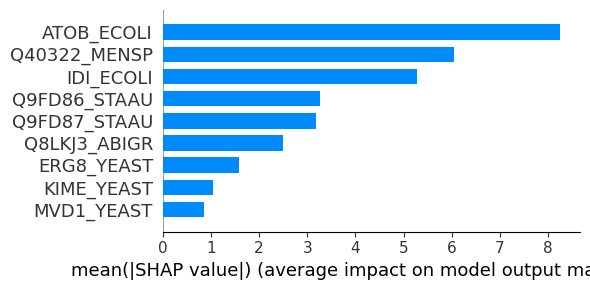

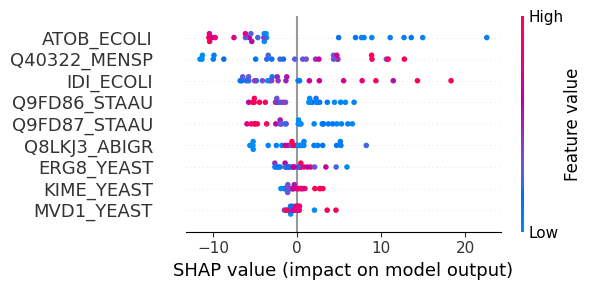

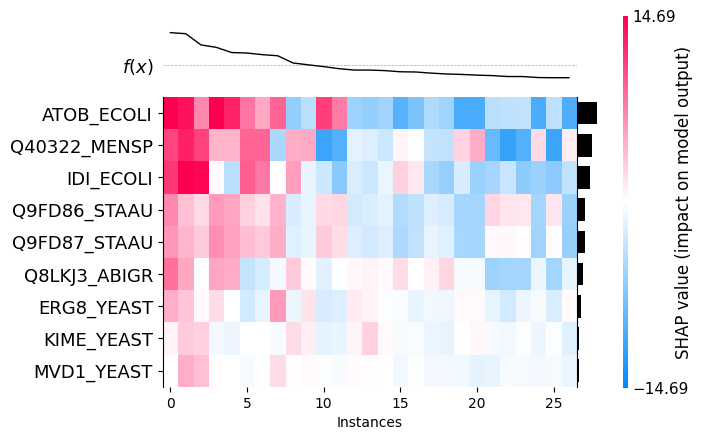

In [6]:
import shap
import matplotlib.pyplot as plt
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])


explainer = shap.Explainer(final_model.predict, df_A[INPUT_VARS])
shap_values = explainer(df_A[INPUT_VARS])
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df_A[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

In [ ]:
feature = "Q40322_MENSP"
pdplot(df_A[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

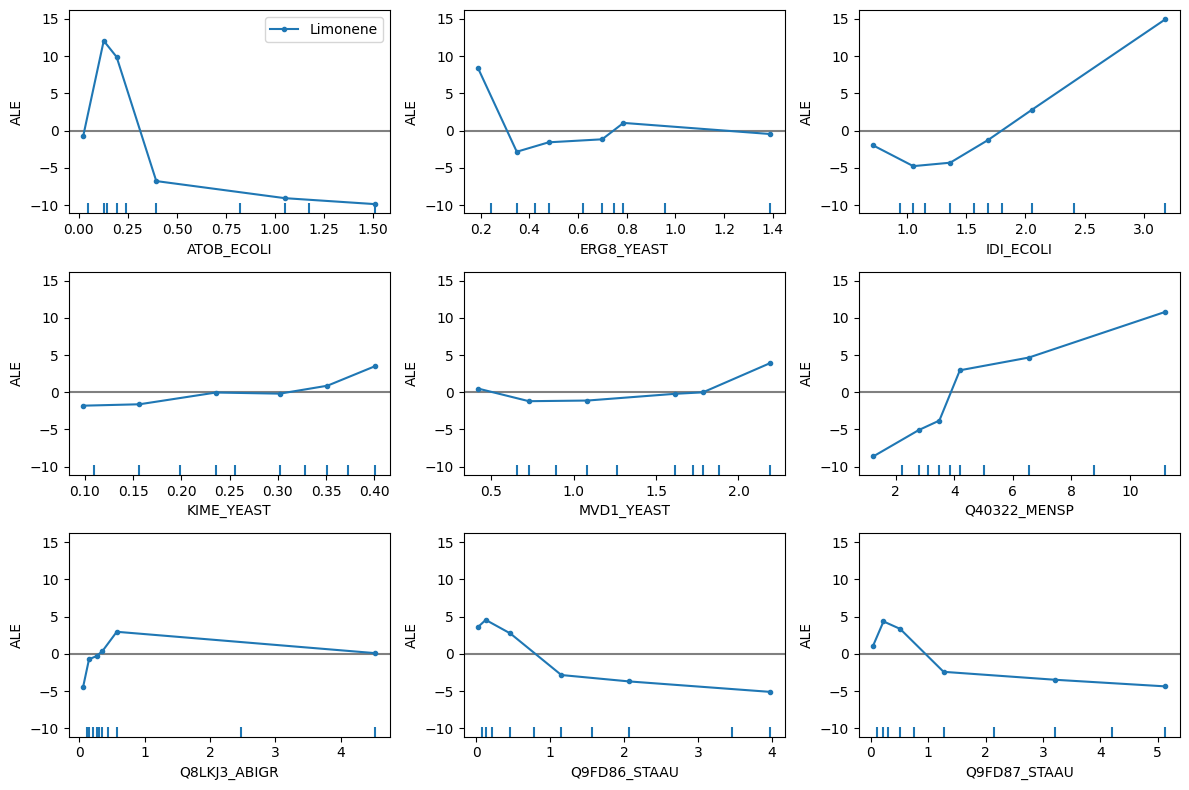

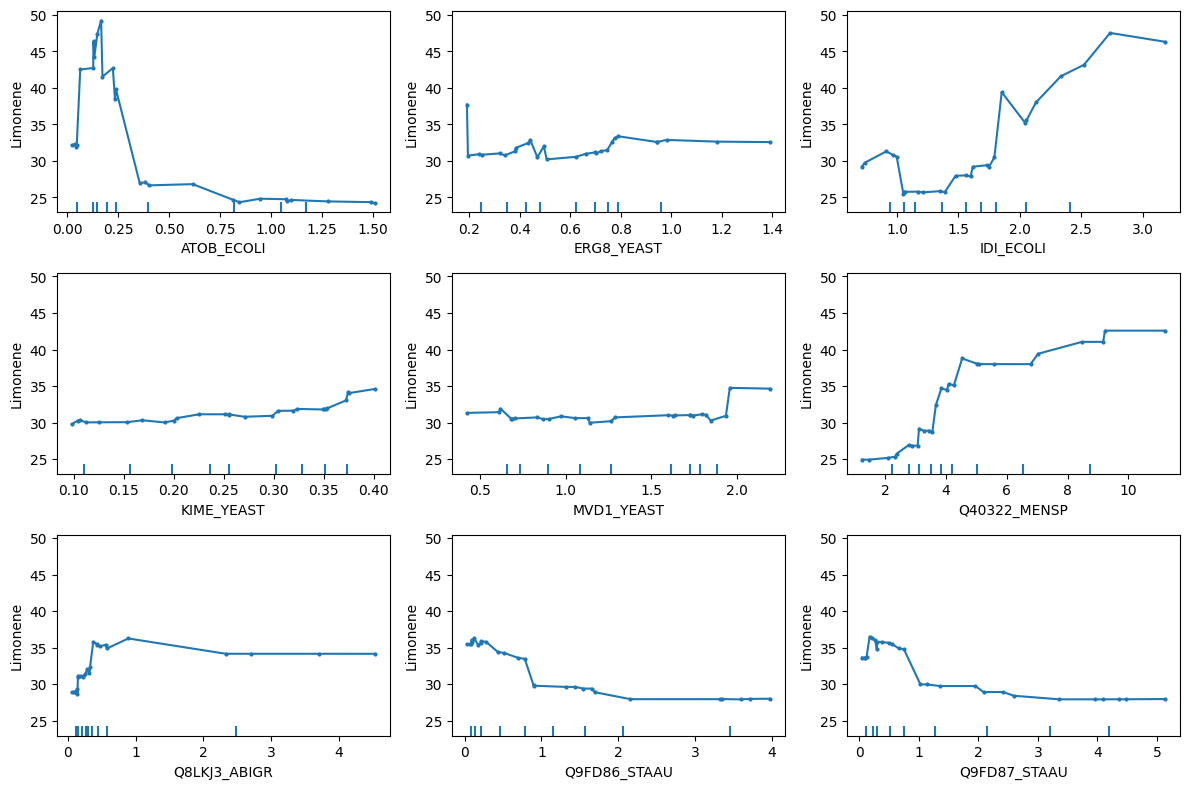

In [9]:
ale = ALE(final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS)
exp = ale.explain(X_train.values)
plot_ale(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

pdp = PartialDependence(
    predictor=final_model.predict, feature_names=INPUT_VARS, target_names=RESPONSE_VARS
)
exp = pdp.explain(X_train.values)
plot_pd(exp, fig_kw={"figwidth": 12, "figheight": 8})
plt.show()

# Sampling

In [14]:
# original bounds
bounds

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU
min,0.0219,0.1899,0.7143,0.0983,0.4215,1.2332,0.0605,0.028,0.0429
max,1.65969,1.51056,3.428,0.43127,2.37081,12.20075,4.97332,4.3719,5.64157


Create new `sampling bounds`, to generate/recommend new strain designs.

In [59]:
sampling_bounds = pd.DataFrame(columns=bounds.columns, index=bounds.index)

sampling_bounds["Q40322_MENSP"].loc["min"] = 8
sampling_bounds["Q40322_MENSP"].loc["max"] = bounds["Q40322_MENSP"].loc["max"]

sampling_bounds["ATOB_ECOLI"].loc["min"] = bounds["ATOB_ECOLI"].loc["min"]
sampling_bounds["ATOB_ECOLI"].loc["max"] = bounds["ATOB_ECOLI"].loc["max"]

sampling_bounds["Q9FD87_STAAU"].loc["min"] = bounds["Q9FD87_STAAU"].loc["min"]
sampling_bounds["Q9FD87_STAAU"].loc["max"] = 1.0

sampling_bounds["Q8LKJ3_ABIGR"].loc["min"] = bounds["Q8LKJ3_ABIGR"].loc["min"]
sampling_bounds["Q8LKJ3_ABIGR"].loc["max"] = 1.0

sampling_bounds["Q9FD86_STAAU"].loc["min"] = bounds["Q9FD86_STAAU"].loc["min"]
sampling_bounds["Q9FD86_STAAU"].loc["max"] = 0.7

sampling_bounds["MVD1_YEAST"].loc["min"] = 0.5
sampling_bounds["MVD1_YEAST"].loc["max"] = bounds["MVD1_YEAST"].loc["max"]

sampling_bounds["ERG8_YEAST"].loc["min"] = bounds["ERG8_YEAST"].loc["min"]
sampling_bounds["ERG8_YEAST"].loc["max"] = 0.6

sampling_bounds["KIME_YEAST"].loc["min"] = 0.2
sampling_bounds["KIME_YEAST"].loc["max"] = bounds["KIME_YEAST"].loc["max"]

sampling_bounds["IDI_ECOLI"].loc["min"] = 2
sampling_bounds["IDI_ECOLI"].loc["max"] = bounds["IDI_ECOLI"].loc["max"]

# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(100)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df.head(10)

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,pred
48,0.147278,0.296111,3.234710,0.337034,1.017786,9.707401,0.893017,0.165898,0.447539,101.328186
70,0.168752,0.304739,2.647020,0.266955,2.005899,10.289872,0.599053,0.563418,0.962654,97.575508
7,0.198173,0.302235,2.610838,0.406777,0.729213,11.155159,0.816228,0.453552,0.307614,88.761971
32,0.089565,0.375716,2.776215,0.417486,2.204398,9.007715,0.741230,0.627473,0.352180,85.693527
13,0.329599,0.272518,2.438502,0.429168,1.659740,10.620219,0.364016,0.035389,0.546161,84.045021
97,0.219673,0.241382,3.031630,0.231017,2.299922,11.039950,0.776052,0.285018,0.910137,83.572289
0,0.079242,0.406022,3.000365,0.238451,2.178271,11.342085,0.680372,0.445599,0.742143,81.062645
18,0.250250,0.355437,2.098336,0.324505,1.565142,12.197531,0.434158,0.404401,0.753104,79.333977
20,0.312416,0.581532,3.104686,0.411859,0.855711,8.798021,0.497745,0.433163,0.285439,77.281540
79,0.683390,0.198780,2.937028,0.424739,1.468557,9.563210,0.827981,0.113842,0.218712,77.253105


# Counterfactuals (`DiCE`)

In [60]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df_A.sort_values("Limonene", ascending=False).index
X_train = X_train.loc[sorted_idx]

def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = X_train[0:1]

d = dice_ml.Data(
    dataframe=df_A, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(
    query_instances,
    total_CFs=3,
    desired_range=[70, 80],
    permitted_range=bounds_to_dict(sampling_bounds),
)

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

Query instance (original outcome : 102.03273010253906)


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1654,0.4407,1.8527,0.2555,1.129,4.5317,0.8922,0.2786,0.3756,102.03273



Diverse Counterfactual set (new outcome: [70, 80])


,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.128,0.4947,2.1665,-,0.8337,10.4113,0.3746,0.1193,0.2126,79.1355972290039
0,0.1484,0.4947,2.1665,-,0.5,8.0,0.3746,0.028,0.2126,76.50013732910156
0,0.2179,-,2.3562,0.2,0.5,11.218,0.2968,0.4523,0.0429,78.4474105834961


In [42]:
# from table_evaluator import TableEvaluator

# real_samples = df_A[INPUT_VARS]
# table_evaluator = TableEvaluator(real_samples, cf_df[INPUT_VARS])
# table_evaluator.visual_evaluation()

# PCA

In [61]:
df_B

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
BL.Mm,1.25540,0.58985,2.29065,1.04860,3.19300,11.31405,1.63235,0.25975,0.41045,119.81367
BL.Mh,1.95983,0.78130,2.59550,1.42496,4.10495,13.59919,1.86762,0.39057,0.65389,127.99494
BL.Ml,0.24012,0.19050,0.94884,0.38070,1.30811,2.72406,0.11237,0.05002,0.08503,6.72018


In [62]:
cf_df

,ATOB_ECOLI,ERG8_YEAST,IDI_ECOLI,KIME_YEAST,MVD1_YEAST,Q40322_MENSP,Q8LKJ3_ABIGR,Q9FD86_STAAU,Q9FD87_STAAU,Limonene
0,0.1280,0.4947,2.1665,0.2555,0.8337,10.4113,0.3746,0.1193,0.2126,79.135597
0,0.1484,0.4947,2.1665,0.2555,0.5000,8.0000,0.3746,0.0280,0.2126,76.500137
0,0.2179,0.4407,2.3562,0.2000,0.5000,11.2180,0.2968,0.4523,0.0429,78.447411


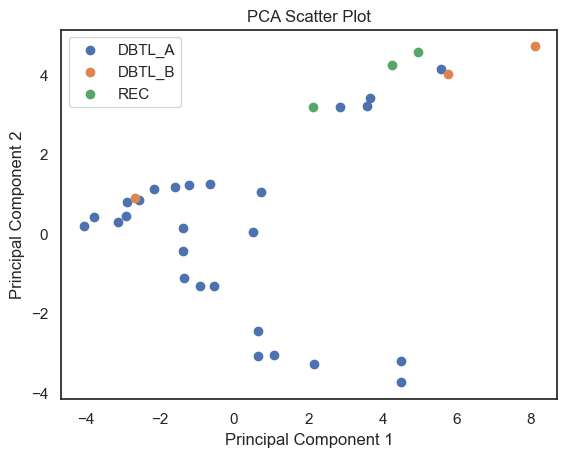

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_A[INPUT_VARS])
trans_df_A = pca.transform(df_A[INPUT_VARS])
trans_df_B = pca.transform(df_B[INPUT_VARS])
trans_rec = pca.transform(cf_df[INPUT_VARS])

# Plot
plt.scatter(trans_df_A[:, 0], trans_df_A[:, 1], label="DBTL_A")
plt.scatter(trans_df_B[:, 0], trans_df_B[:, 1], label="DBTL_B")
plt.scatter(trans_rec[:, 0], trans_rec[:, 1], label="REC")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Scatter Plot")
plt.legend()
plt.show()